In [15]:
from rtlsdr import RtlSdr
import pylab

# NOTE(dominic): This is super lame, but iptyhon kernels are running in the directory they are
# contained. That means, we cannot access any other sub-modules from within these notebooks.
# We resolve this by temporarily adding the parent directory to the path.

import os
import sys
sys.path.insert(0, os.path.abspath('..'))

from util.plotting import compute_fft_plot, compute_fft_plot_from_sample_rate, compute_frequency_response
from util.filtering import compute_lpf_coeff, filter_complex_signal, filter_real_signal
from util.data_io import read_sdriq_data
from util.demodulation import demodulate_signal, chunked_demodulate_signal

import numpy as np
from scipy.io import wavfile

loaded raw signal of length 230400064
Signal min: 25.504902
Signal mean: 85.26922
Signal max: 149.20624


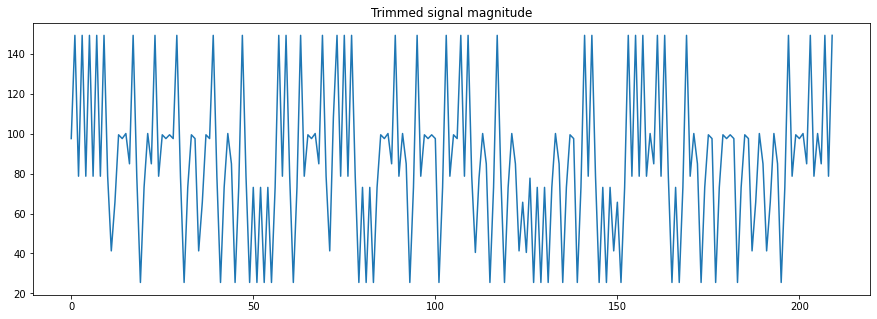

In [20]:
signal = read_sdriq_data("/Users/benjaminpattison/Documents/Projects/satNav/SDR_satellite_tracking/data/gqrx_20211121_204702_435103000_1920000_fc_cropped.raw")
center_frequency = 435103000
sample_frequency = 1920000
trimmed_signal = signal[169:int(169+sample_frequency/9600)]

print("Signal min:", np.min(np.abs(trimmed_signal)))
print("Signal mean:", np.mean(np.abs(trimmed_signal)))
print("Signal max:", np.max(np.abs(trimmed_signal)))

pylab.figure(1,figsize=(15,5))
pylab.plot(np.abs(trimmed_signal))
pylab.title("Trimmed signal magnitude")
pylab.show(1)

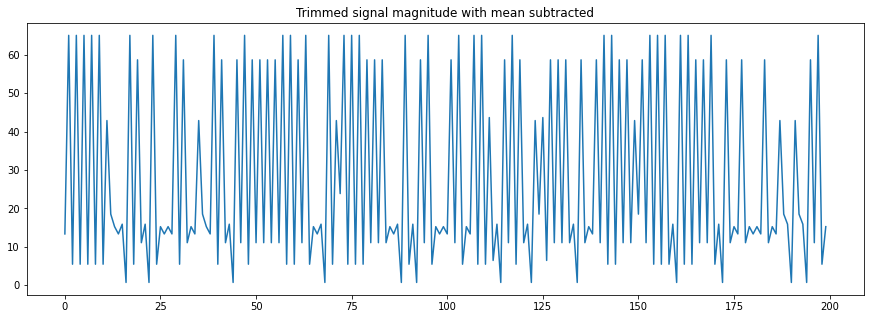

In [17]:
trimmed_signal_no_mean = np.abs(trimmed_signal) - np.mean(np.abs(trimmed_signal))
pylab.figure(2,figsize=(15,5))
pylab.plot(np.abs(trimmed_signal_no_mean))
pylab.title("Trimmed signal magnitude with mean subtracted")
pylab.show(2)

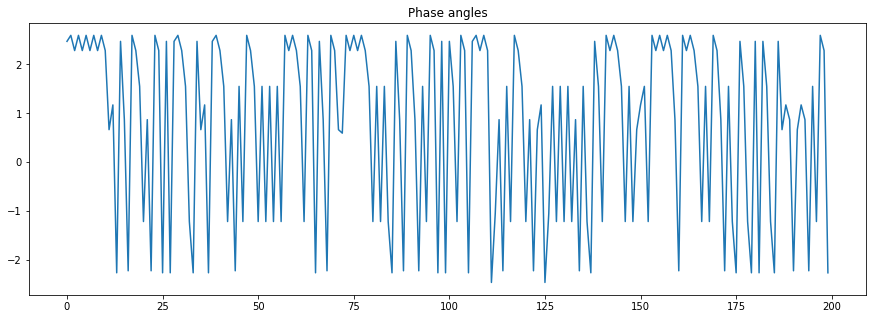

In [18]:
phase_angles = np.angle(trimmed_signal)

pylab.figure(3,figsize=[15,5])
pylab.plot(phase_angles)
pylab.title("Phase angles")
pylab.show(3)


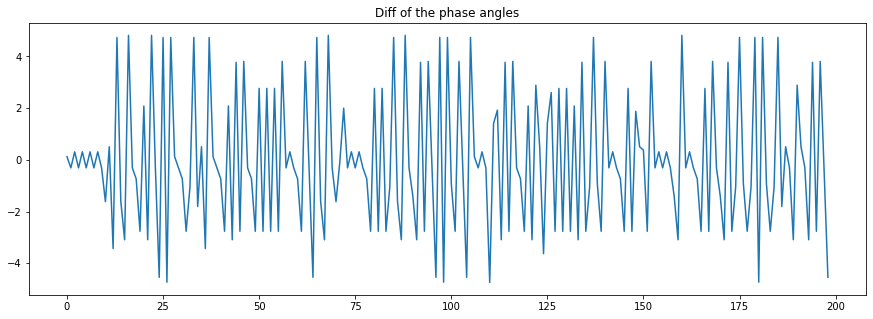

In [19]:
phase_angle_diff = np.diff(phase_angles)

pylab.figure(4,figsize=[15,5])
pylab.plot(phase_angle_diff)
pylab.title("Diff of the phase angles")
pylab.show(4)

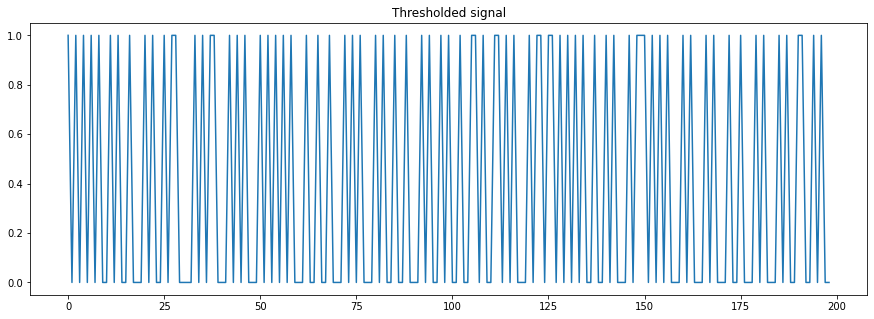

In [22]:
threshold_signal = np.empty(phase_angle_diff.shape[0])
threshold_signal[phase_angle_diff<0] = 0
threshold_signal[phase_angle_diff>0] = 1

pylab.figure(5,figsize=[15,5])
pylab.plot(threshold_signal)
pylab.title("Thresholded signal")
pylab.show(5)